Autor: Florencia B. Hidalgo <br>


<h1 style='color:white'>Optimización de ventas - Impulso de performance comercial</h1>
<center><img src ='/work/img/portada.png'></center>

In [ ]:
# Instalación de dependencias necesarias
!pip install openpyxl==3.0.10     #para que pueda leer correctamente el archivo .xlsx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.1/242.1 KB 8.3 MB/s eta 0:00:00
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
# Importación de librerías usadas
import numpy as np
import pandas as pd
import sqlite3 as sql3
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

<h2>Paso 1: Alcances del proyecto y obtener datos</h2>
<h3>Alcances del proyecto</h3>
<p>En este proyecto vamos a integrar tres sets de datos con lista de vendedores, lista de artículos y registro de operaciones de un mes, que nos ayudarán a responder a las preguntas: </p>
<ul>
<li>¿Cuál es el artículo más vendido? (unidades)</li>
<li>¿Qué artículo es el que más ingresos nos proporcionó?</li>
<li>¿A qué vendedor debe otorgarse el bono por "Mejor vendedor del mes"?</li>
<li>¿Hay grandes variaciones en ventas a lo largo del mes?</li>
</ul>
<p>Para este proyecto utilizaremos herramientas de Pandas para análisis exploratorio, Numpy para el análisis de ciertas columnas y Matplotlib/Seaborn para visualización de resultados.</p>

<h4>Descripción y obtención de los datos</h4>
<h4>Fuentes de datos</h4>
<ul>
<li>articles.db: BD con datos de los artículos.</li>
<li>sellers.xlsx: datos de los vendedores.</li>
<li>orders.csv: registro de las ventas de un mes.</li>
</ul>

##### Importación de articles.db (SQL) y transformación a DataFrame

In [ ]:
conn = sql3.connect('/work/data/articles.db')

# Se toma la columna article_id como index del DataFrame y como el método read_sql_query no la elimina, 
# hago un drop de esa columna posterior, ya que quedan todos NaN y no tiene opción inplace.

sql_query = pd.read_sql_query('SELECT * FROM articles', conn, index_col='article_id')
df_articles = pd.DataFrame(sql_query, columns= ['article_id','article_name','unit_price'])
df_articles = df_articles.drop('article_id', axis=1)

# Aprovecho a ver una muestra de esos datos y ver si se importó correctamente.
print(df_articles.head(2))

           article_name unit_price
article_id                        
20015        Smartphone     525.00
20016           Full Pc    2127.81


##### Importación de sellers.xlsx (Excel) y transformación a DataFrame

In [ ]:
# Se toma la columna seller_id como index del DataFrame
df_sellers = pd.read_excel('/work/data/sellers.xlsx', index_col='seller_id')

# Aprovecho a ver una muestra de esos datos y ver si se importó correctamente.
print(df_sellers.head(2))

                seller_name
seller_id                  
1          Aveline Swanwick
2                  Jase Doy


##### Importación de orders.csv (CSV) y transformación a DataFrame

In [ ]:
df_orders = pd.read_csv('/work/data/orders.csv')

#Aprovecho a ver una muestra de esos datos y ver si se importó correctamente.
print(df_orders.head(2))

   order_id  week  article_id  quantity  seller_id country_name
0     15024     1       20039        10         10         Peru
1     15025     1       20029        15          5         Peru


Con esto vemos el potencial de poder importar distintos tipos de datos y poder trabajarlos como uno solo. En este caso obtenemos datos de SQL, de Excel y de un archivo separado por comas (CSV), tres orígenes bien distintos pero pudiendo trabajarlos como iguales a través de un DataFrame.

<h2>Paso 2: Explorar y preparar los datos</h2>

<h3>Exploración de datos</h3>

<b>Exploración del DataFrame de Artículos</b>

In [ ]:
print('Muestra de datos')
print(df_articles.sample())

Muestra de datos
           article_name unit_price
article_id                        
20042        Sata Cable       2.14


In [ ]:
print('Dimensión del DataFrame')
print(df_articles.shape)

Dimensión del DataFrame
(31, 2)


In [ ]:
print('Búsqueda de valores nulos')
print(df_articles.isnull().sum())

Búsqueda de valores nulos
article_name    0
unit_price      0
dtype: int64


In [ ]:
print('Tipo de dato por columna')
print(df_articles.dtypes)

Tipo de dato por columna
article_name    object
unit_price      object
dtype: object


<b>Exploración del DataFrame de sellers</b>

In [ ]:
print('Muestra de datos')
print(df_sellers.sample())

Muestra de datos
              seller_name
seller_id                
14         Janel O'Curran


In [ ]:
print('Dimensión del dataframe')
print(df_sellers.shape)

Dimensión del dataframe
(15, 1)


In [ ]:
print('Búsqueda de valores nulos')
print(df_sellers.isnull().sum())

Búsqueda de valores nulos
seller_name    0
dtype: int64


In [ ]:
print('Tipo de dato por columna')
print(df_sellers.dtypes)

Tipo de dato por columna
seller_name    object
dtype: object


<b>Exploración del DataFrame orders</b>

In [ ]:
print('Muestra de datos')
print(df_orders.sample())

Muestra de datos
    order_id  week  article_id  quantity  seller_id country_name
45     15069     1       20032         2         15     Honduras


In [ ]:
print('Dimensión del dataframe')
print(df_orders.shape)

Dimensión del dataframe
(1000, 6)


In [ ]:
print('Búsqueda de valores nulos')
print(df_orders.isnull().sum())

Búsqueda de valores nulos
order_id        0
week            0
article_id      0
quantity        0
seller_id       0
country_name    0
dtype: int64


In [ ]:
print('Tipo de dato por columna')
print(df_orders.dtypes)

Tipo de dato por columna
order_id         int64
week             int64
article_id       int64
quantity         int64
seller_id        int64
country_name    object
dtype: object


<h3>Preparación de datos</h3>
<p>Encuentro un inconveniente en la columna de precios de los artículos. Al momento de pasarlo a DataFrame, Pandas interpretó que esa columna correspondía a un String, sin embargo corresponde a un número decimal. Por lo tanto necesito cambiar el formato cadena a float.</p>

Para una visualización más amena, los precios se expresarán con el símbolo "$" y además tendrá separador de miles y dos decimales.

In [ ]:
pd.options.display.float_format = '$ {:,.2f}'.format

In [ ]:
df_articles['unit_price'] = df_articles['unit_price'].astype(float)
print(df_articles.dtypes)

article_name     object
unit_price      float64
dtype: object


In [ ]:
print(df_articles.head(3))

           article_name  unit_price
article_id                         
20015        Smartphone    $ 525.00
20016           Full Pc  $ 2,127.81
20017           Monitor    $ 230.00


<h2>Paso 3: Definir el modelo de datos</h2>
<p>Crearemos un nuevo dataframe a partir de las fuentes de datos proporcionados haciendo un JOIN entre las diferentes key</p>
<img src='img/Diagrama.png'>


<h2>Paso 4: Correr los pipelines para modelar los datos</h2>
<p>Llamamos pipeline a una serie de procesos en el cual la salida de un proceso es la entrada que utiliza el siguiente proceso. <br>
Esto es muy útil debido a que si tengo nuevos datos (por ejemplo, los datos del mes siguiente de esta empresa), no debería realizar todo este código nuevamente sino directamente usarlo con nueva información y obteniendo los resultados inmediatamente.</p>

Para crear el DataFrame que va a contener toda la información según el modelo de datos, parto desde el DataFrame orders

In [ ]:
data = df_orders.copy()
data.head(2)

,order_id,week,article_id,quantity,seller_id,country_name
0,15024,1,20039,10,10,Peru
1,15025,1,20029,15,5,Peru


Voy a unir los distintos DataFrame utilizando el método merge (equivalente en Pandas a JOIN en SQL) uniendo de la siguiente manera:
<li>article_id del DataFrame Data con el index de df_articles para obtener el nombre y precio unitario</li>
<li>seller_id del DataFrame Data con el index de df_sellers para obtener el nombre del vendedor</li>

Posteriormente tengo dropear las columnas article_id y seller_id del DataFrame data ya que no tiene sentido que sigan ahí.


In [ ]:
data_article = data.merge(df_articles, left_on='article_id', right_on=df_articles.index, how='inner')
data_article.head(3)

,order_id,week,article_id,quantity,seller_id,country_name,article_name,unit_price
0,15024,1,20039,10,10,Peru,Water Cooling,$ 67.50
1,15047,1,20039,5,9,Argentina,Water Cooling,$ 67.50
2,15058,1,20039,9,12,Mexico,Water Cooling,$ 67.50


In [ ]:
data_article_seller = data_article.merge(df_sellers, left_on='seller_id', right_on=df_sellers.index, how='inner')
data_article_seller.head(3)

,order_id,week,article_id,quantity,seller_id,country_name,article_name,unit_price,seller_name
0,15024,1,20039,10,10,Peru,Water Cooling,$ 67.50,Cirilo Grandham
1,15892,3,20039,15,10,Brazil,Water Cooling,$ 67.50,Cirilo Grandham
2,15732,3,20029,6,10,Guatemala,Mouse,$ 30.30,Cirilo Grandham


In [ ]:
data_unificada = data_article_seller.drop(['article_id','seller_id'], axis=1)
data_unificada.head(3)

,order_id,week,quantity,country_name,article_name,unit_price,seller_name
0,15024,1,10,Peru,Water Cooling,$ 67.50,Cirilo Grandham
1,15892,3,15,Brazil,Water Cooling,$ 67.50,Cirilo Grandham
2,15732,3,6,Guatemala,Mouse,$ 30.30,Cirilo Grandham


Debido a que tengo las cantidades (`quantity`) y el precio unitario (`unit_price`), pero al trabajar con datos me va a ser mucho más eficiente tener los montos totales de cada orden, multiplico ambos generando una nueva columna `total_amount`.  <br>

Luego de esto, la columna `unit_price` y `order_id`ya no va a ser utilizada, por lo tanto sea la dropea.

In [ ]:
data_unificada['total_amount'] = data_unificada['quantity'] * data_unificada['unit_price']
data_unificada.head(3)

,order_id,week,quantity,country_name,article_name,unit_price,seller_name,total_amount
0,15024,1,10,Peru,Water Cooling,$ 67.50,Cirilo Grandham,$ 675.00
1,15892,3,15,Brazil,Water Cooling,$ 67.50,Cirilo Grandham,"$ 1,012.50"
2,15732,3,6,Guatemala,Mouse,$ 30.30,Cirilo Grandham,$ 181.80


In [ ]:
data_a_trabajar = data_unificada.drop(['unit_price','order_id'], axis=1)
data_a_trabajar.head(3)

,week,quantity,country_name,article_name,seller_name,total_amount
0,1,10,Peru,Water Cooling,Cirilo Grandham,$ 675.00
1,3,15,Brazil,Water Cooling,Cirilo Grandham,"$ 1,012.50"
2,3,6,Guatemala,Mouse,Cirilo Grandham,$ 181.80


Por último, verifico como quedaron los tipos de datos por si hay que hacer alguna última corrección en ellos.

In [ ]:
data_a_trabajar.dtypes

week              int64
quantity          int64
country_name     object
article_name     object
seller_name      object
total_amount    float64
dtype: object

La columna `total_amount` se encuentra con tipo de dato `float` necesario para poder darle el formato monetario.

<h2>Paso 5: Responder las preguntas</h2>


<h3>1. ¿Cuál es el artículo más vendido? (en unidades)</h3>

<h4> Resolución analítica</h4>

Agrupo el DataFrame por `article_name` y luego obtengo el máximo de la columna `quantity`.

In [ ]:
group_vendidos = data_a_trabajar.groupby('article_name').sum().sort_values('quantity', ascending=False)
mas_vendido = group_vendidos.loc[:,'quantity'].head(1).index[0]
mas_vendido_cantidad = group_vendidos.loc[:,'quantity'].head(1)[0]
print("El artículo más vendido es", mas_vendido, "con", mas_vendido_cantidad, "unidades vendidas.")

El artículo más vendido es HDD con 413 unidades vendidas.


<h4> Resolución gráfica</h4>

En este caso es preferible ver todos los artículos y sus cantidades vendidas para tener un panorama más visible comparativo entre ellos. Para esto utilizo la resolución anterior, pero ordeno el DataFrame para que esté ordenado de mayor a menor, dejando los mayores del lado izquierdo.

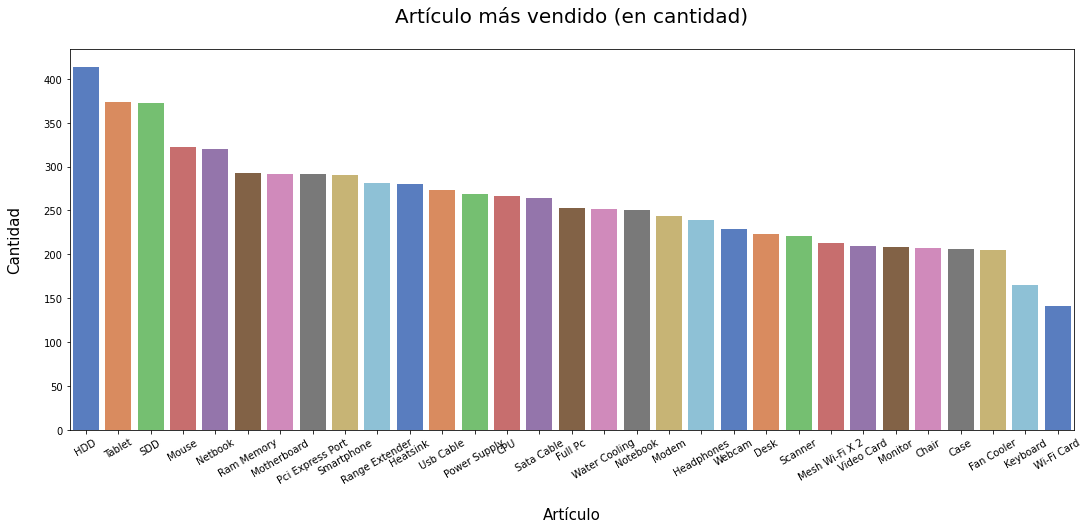

In [ ]:
rcParams['figure.figsize'] = 18,7
ax = sns.barplot(data=group_vendidos, x=group_vendidos.index, y='quantity', palette='muted')
ax.set_xlabel('\nArtículo', fontsize = 15)
ax.set_ylabel('Cantidad\n', fontsize = 15)
plt.xticks(rotation=30)
plt.title('Artículo más vendido (en cantidad)\n', fontsize=20)
ax.tick_params(axis='both' , labelsize=10)
plt.show()

<h4>Respuesta</h4>
El artículo más vendido es HDD con 413 unidades vendidas. Sin embargo se puede ver en el gráfico que la cantidad vendidas de artículos es bastante uniforme.

<h3>2. ¿Qué artículo es el que más ingresos nos proporcionó?</h3>

<h4> Resolución analítica</h4>

Agrupo el DataFrame por `article_name` y luego obtengo el máximo de la columna `total_amount`.

In [ ]:
group_ingresos = data_a_trabajar.groupby('article_name').sum().sort_values('total_amount', ascending=False)
mas_ingresos = group_ingresos.loc[:,'total_amount'].head(1).index[0]
mas_ingresos_cantidad = round(group_ingresos.loc[:,'total_amount'].head(1)[0],2)
print("El artículo que generó mayor ingreso es", mas_ingresos, "por un monto de $", mas_ingresos_cantidad)

El artículo que generó mayor ingreso es Full Pc por un monto de $ 538335.93


<h4>Resolución Gráfica</h4>

Para ver de manera gráfica cuales son los artículos que más ingresos generaron, se van a tomar los primeros cuatro que mayor ingreso generaron y el resto se agrupa en un solo bloque como `Otros`. <br>
Además, en esa gráfica se separa el que generó mayores ingresos para destacarlo por sobre el resto fácilmente.

In [ ]:
cat_principales = group_ingresos[group_ingresos['total_amount'] > 50000]['total_amount']
cat_menores = group_ingresos[group_ingresos['total_amount'] < 50000]['total_amount'].sum()
cat_menores = pd.Series(cat_menores, index=['Otros'])
amount_plot = pd.concat([cat_principales,cat_menores])
print('Cuatro componentes que más generaron ingresos y el último agrupado todos los demás')
amount_plot

Cuatro componentes que más generaron ingresos y el último agrupado todos los demás


Full Pc      $ 538,335.93
Notebook     $ 251,000.00
Smartphone   $ 152,250.00
Chair         $ 69,477.48
Otros        $ 464,744.43
dtype: float64

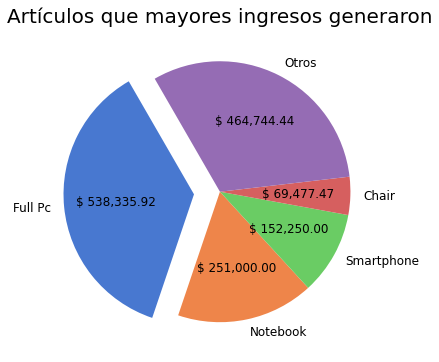

In [ ]:
rcParams['figure.figsize'] = 6, 6
explode = (0.2,0,0,0,0)
total = amount_plot.sum()
plt.title('Artículos que mayores ingresos generaron', fontsize=20)
plt.pie(x=amount_plot, labels=amount_plot.index, colors=sns.color_palette('muted'), explode=explode, startangle=120, textprops={'fontsize': 12}, autopct = lambda p: '$ {:,.2f}'.format(p * total / 100))
plt.show()

<h4>Respuesta</h4>
El artículo que más ingresos generó es Full Pc por $538.335,92 superando ampliamente a los otros artículos. En el gráfico se puede ver que incluso supera a la totalidad de la categoría "Otros".

<h3>3. ¿A qué vendedor debe otorgarse el bono por "Mejor vendedor del mes"?</h3>

<h4>Resolución analítica</h4>

Para obtener el mejor vendedor del mes se agrupa el DataFrame por la columna `seller_name` y luego se la ordena por `total_amount`.

In [ ]:
group_bono = data_a_trabajar.groupby('seller_name').sum().sort_values('total_amount', ascending=False)
mejor_vendedor = group_bono.head(1).index[0]
mejor_vendedor_monto = round(group_bono.head(1)['total_amount'].values[0],2)
print("El vendedor que más vendio en el mes es", mejor_vendedor, "por un monto de $", mejor_vendedor_monto)

El vendedor que más vendio en el mes es Janel O'Curran por un monto de $ 192832.47


<h4>Resolución gráfica</h4>

En este caso es preferible ver todos los vendedores y los montos vendidos por cada uno para tener un panorama más visible comparativo entre ellos. Para esto utilizo la resolución anterior, pero ordeno el DataFrame para que esté ordenado de mayor a menor, dejando los mayores del lado izquierdo.

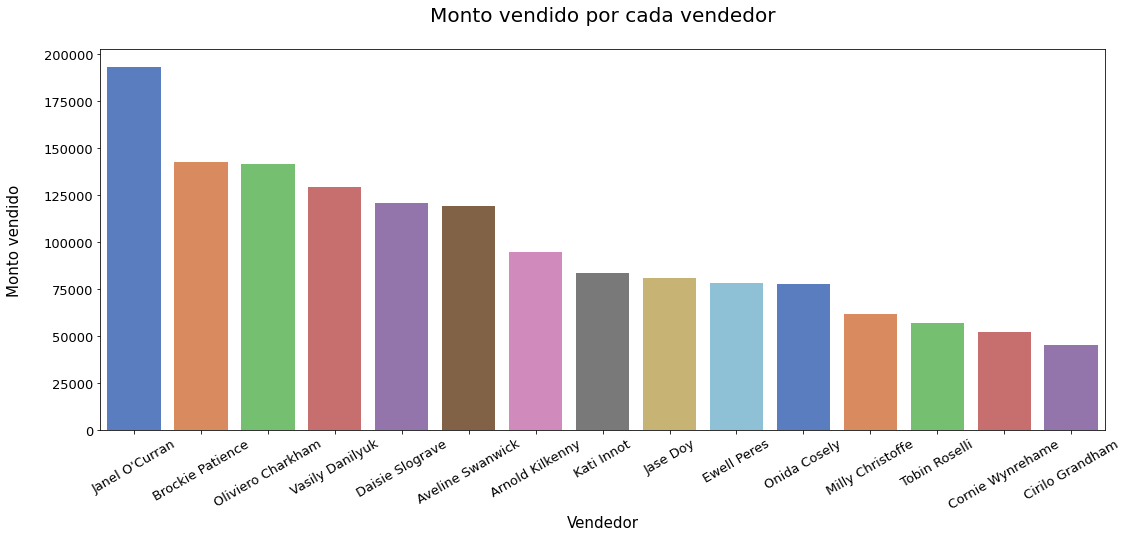

In [ ]:
rcParams['figure.figsize'] = 18,7
ax = sns.barplot(data=group_bono, x=group_bono.index, y='total_amount', palette='muted')
ax.set_xlabel('Vendedor', fontsize = 15)
ax.set_ylabel('Monto vendido\n', fontsize = 15)
plt.xticks(rotation=30)
plt.title('Monto vendido por cada vendedor\n', fontsize=20)
ax.tick_params(axis='both' , labelsize=13)
plt.show()

<h4>Respuesta</h4>
El bono al mejor vendedor del mes corresponde a Janel O'Curran por vender $192.832,47.

<h3>4. ¿Hay grandes variaciones en ventas a lo largo del mes?</h3>
<h4>Si es así, ¿en qué momento debería lanzar una campaña de promociones?</h4>


<h4>Resolución analítica</h4>

Para obtener la variación de ventas en el mes se agrupa el DataFrame por la columna `week` y luego se la ordena por `total_amount`. Cabe destacar que la columna `week` si bien está expresada numéricamente, se la trata como una variable categórica.

Además se le agrega una columna de diferencia en porcentajes comparativa a la semana de mayor venta del mes.

In [ ]:
group_variacion = data_a_trabajar.groupby('week').sum().sort_values('total_amount', ascending=False)
print(group_variacion['total_amount'])

week
1   $ 507,458.81
2   $ 415,364.44
3   $ 329,140.03
4   $ 223,844.56
Name: total_amount, dtype: float64


In [ ]:
maximo_mensual = group_variacion['total_amount'].max()

#tengo que cambiar la configuración de formato de los float para que los muestre como %
pd.options.display.float_format = '% {:,.2f}'.format
(group_variacion['total_amount'] / maximo_mensual) - 1 

week
1    % 0.00
2   % -0.18
3   % -0.35
4   % -0.56
Name: total_amount, dtype: float64

<h4>Resolución gráfica</h4>

En este caso es preferible ver todas las semanas y los montos vendidos en cada una para tener un panorama más visible comparativo entre ellas. Además se agrega una línea de tendencia mensual para explicar gráficamente esa variabilidad.

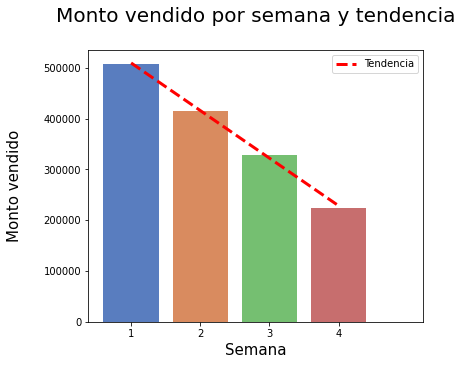

In [ ]:
# RESOLUCIÓN GRÁFICA
rcParams['figure.figsize'] = 6,5

#gráfico de barras
ax = sns.barplot(data=group_variacion, x=group_variacion.index, y='total_amount', palette='muted')
ax.set_xlabel('Semana', fontsize = 15)
ax.set_ylabel('Monto vendido\n', fontsize = 15)
ax.set_label('Label via method')

# gráfico de línea de tendencia
ax = plt.scatter(group_variacion.index, group_variacion['total_amount'], marker='None')
z = np.polyfit(group_variacion.index, group_variacion['total_amount'], 1)
p = np.poly1d(z)
plt.plot(group_variacion.index-1, p(group_variacion.index),"r--", linewidth=3, label='Tendencia')

plt.legend()
plt.title('Monto vendido por semana y tendencia\n', fontsize=20)
plt.show()

<h4>Respuesta</h4>

Existen grandes variaciones de ventas a lo largo del mes. La primera semana es la que mayor volúmen de ventas tiene, la segunda semana decae un 18%, la tercera un 35% y la cuarta semana un 56%, todas respecto a la primer semana. Esto se evidencia en la pendiente negativa de la línea de tendencia del gráfico. Por esto mismo se recomienda lanzar una campaña de promociones en la tercera y/o cuarta semana.

In [ ]:
#vuelvo a configurar el formato $ para todos los float
pd.options.display.float_format = '$ {:,.2f}'.format

<h3>5. ¿Qué país genera el mayor ingreso por unidad vendida?</h3>

<h4>Hacer un análisis comparativo entre monto vendido y cantidad vendida discriminada por país y obtener el país con mayor ingreso unitario</h4>

<h4>Resolución analítica</h4>

Agrupo el DataFrame por `country_name` y luego sumo la columna `quantity` ordenándolo de mayor a menor por la columna `total_amount`.

In [ ]:
group_pais = data_a_trabajar.groupby('country_name').sum().sort_values('total_amount', ascending=False)
print(group_pais[['quantity','total_amount']])

              quantity  total_amount
country_name                        
Brazil            2515  $ 441,271.85
Argentina          947  $ 205,832.78
Colombia           881  $ 177,514.29
Peru              1027  $ 161,421.12
Mexico             846  $ 138,619.99
Venezuela          320   $ 77,684.52
El Salvador        111   $ 57,391.26
Guatemala          202   $ 52,579.25
Honduras           303   $ 36,763.56
Costa Rica         145   $ 34,606.50
Chile              231   $ 24,660.98
Bolivia            181   $ 22,682.80
Uruguay             92   $ 17,843.09
Ecuador            129   $ 17,475.30
Paraguay           123    $ 8,195.12
Puerto Rico         12    $ 1,265.43


Luego hago la división de `total_amount` / `quantity` para obtener un ingreso por unidad de cada país y quedarme con el mayor de ellos.

In [ ]:
ingreso_unitario_por_pais = (group_pais['total_amount'] / group_pais['quantity']).sort_values(ascending=False)
print("El país que mayor ingresos generó fue", ingreso_unitario_por_pais.index[0], "por un monto unitario de $", round(ingreso_unitario_por_pais[0],2))

El país que mayor ingresos generó fue El Salvador por un monto unitario de $ 517.04


<h4>Resolución gráfica</h4>

Al DataFrame anterior lo grafico. Se asignan barras al monto vendido (eje Y izquierdo) y línea a la cantidad vendida (eje Y derecho).

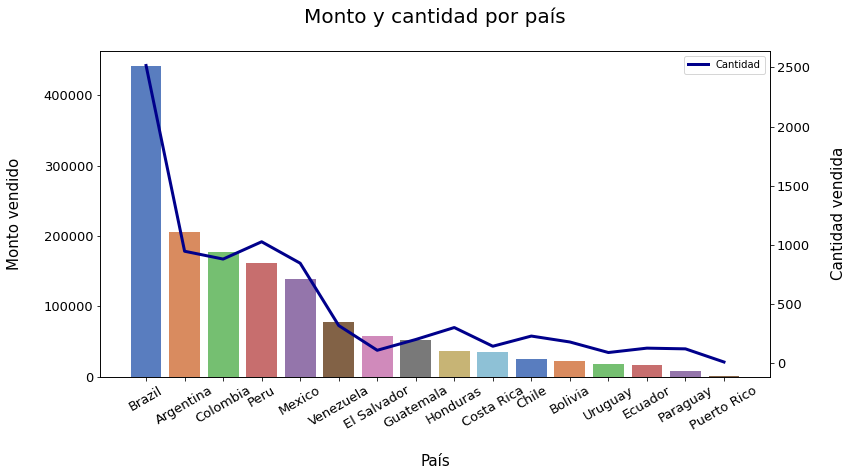

In [ ]:
rcParams['figure.figsize'] = 12,6
ax1 = sns.barplot(data=group_pais, x=group_pais.index, y='total_amount', palette='muted')
plt.xticks(rotation=30)

ax2 = ax1.twinx()
ax2 = sns.lineplot(data=group_pais, x=group_pais.index, y='quantity', color='darkblue', linewidth=3, ax=ax2, label='Cantidad')

ax1.set_xlabel('\nPaís', fontsize = 15)
ax1.set_ylabel('Monto vendido\n', fontsize = 15)
ax2.set_ylabel('\nCantidad vendida', fontsize = 15)

ax1.tick_params(axis='both' , labelsize=13)
ax2.tick_params(axis='both' , labelsize=13)

plt.title('Monto y cantidad por país\n', fontsize=20)
plt.show()

In [ ]:
#preparar los datos para poder mostrarlos correctamente en el gráfico
ingreso_unitario_por_pais.reset_index
ing_unitario_graf = ingreso_unitario_por_pais.to_frame()
ing_unitario_graf = ing_unitario_graf.rename(columns={0:'Monto_unitario'})

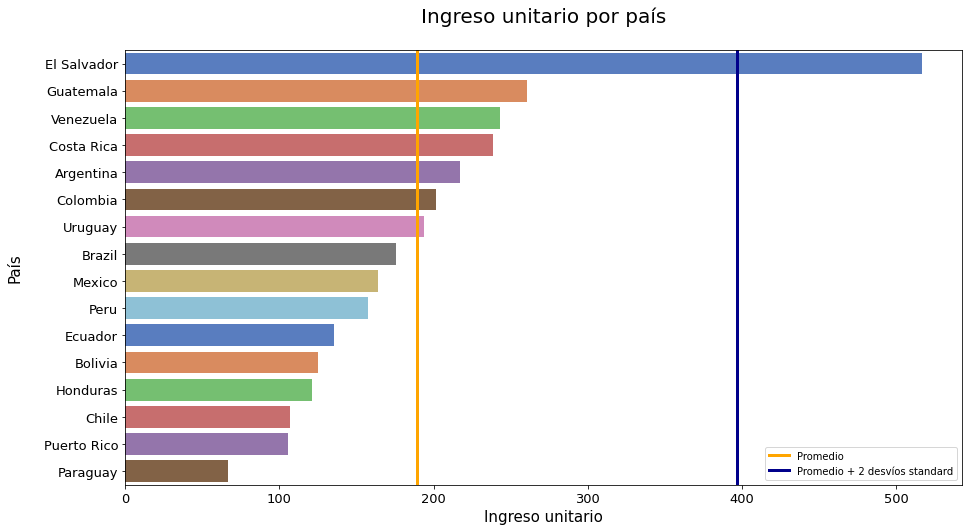

In [ ]:
rcParams['figure.figsize'] = 15,8
ax = sns.barplot(data=ing_unitario_graf , y=ing_unitario_graf .index, x=ing_unitario_graf.Monto_unitario, orient='h', palette='muted')

ax.set_xlabel('Ingreso unitario', fontsize = 15)
ax.set_ylabel('País\n', fontsize = 15)

ax.axvline(x=ing_unitario_graf.mean()[0], color='orange', linewidth=3, label='Promedio')
ax.axvline(x=(ing_unitario_graf.mean() + 2 * ing_unitario_graf.std())[0], color='darkblue', linewidth=3, label='Promedio + 2 desvíos standard')

ax.tick_params(axis='both', labelsize=13)

plt.legend()
plt.title('Ingreso unitario por país\n', fontsize=20)
plt.show()

<h4>Respuesta</h4>

El país que genera mayor ingreso por unidad vendida es El Salvador con $517.04 por cada unidad vendida allí. A primera vista podría incrementarse las promociones en dicho lugar porque podría ser el más rentable superando ampliamente al segundo (Guatemala) y su diferencia es significativa. Incluso supera cómodamente al promedio más dos desvíos standard como se ve en el gráfico.<br><br>
Nota: La terminología buscada era 'País más rentable', pero no se puede afirmar ya que al tener pocos datos no podría afirmarse tal cosa (por no tener los costos), por eso se optó por 'Ingreso unitario'.

<h3>6. ¿Cuál es la distribución de unidades compradas por cada pedido?</h3>

Se quiere estudiar la cantidad de productos comprados por cada pedido y su distribución, para comprender si hay mayoría de compras unitarias, o por el contrario una mayoría de compras al por mayor, o un mix de ambas. <br>
Analizar la distribución de la cantidad por pedido.

<h4>Resolución analítica</h4>

Hago un conteo de cuantas veces se repiten las cantidades en la columna `quantity` en todo el DataFrame.

In [ ]:
contador = data_a_trabajar['quantity'].value_counts()
contador_df = contador.to_frame().reset_index()
contador_df = contador_df.rename(columns={"index":"Cantidad_por_pedido","quantity":"Repeticiones"})
contador_df = contador_df.sort_values('Cantidad_por_pedido', ascending=True)
contador_df = contador_df.reset_index(drop=True)
print(contador_df.sort_values('Cantidad_por_pedido', ascending=True))

    Cantidad_por_pedido  Repeticiones
0                     1            72
1                     2            64
2                     3            55
3                     4            63
4                     5            72
5                     6            60
6                     7            77
7                     8            69
8                     9            64
9                    10            65
10                   11            71
11                   12            61
12                   13            67
13                   14            73
14                   15            67


<h4>Resolución gráfica</h4>

Realizo un gráfico de distribución para la variable `quantity` para ver como está distribuído los valores y sus frecuencias.

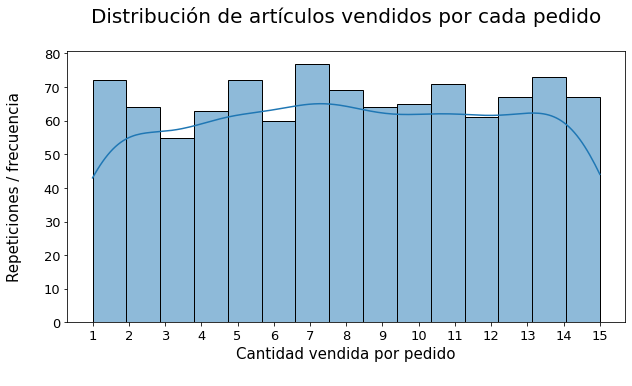

In [ ]:
rcParams['figure.figsize'] = 10,5

ax = sns.histplot(data=data_a_trabajar, x='quantity', kde=True, bins=data_a_trabajar.quantity.max())
ax.set_xlabel('Cantidad vendida por pedido\n', fontsize = 15)
ax.set_ylabel('Repeticiones / frecuencia\n', fontsize = 15)
ax.tick_params(axis='both' , labelsize=13)

eje_x = np.arange(data_a_trabajar.quantity.min(), data_a_trabajar.quantity.max()+1, 1)
plt.xticks(eje_x)

plt.title('Distribución de artículos vendidos por cada pedido\n', fontsize=20)
plt.show()

<h4>Respuesta</h4>
En la resolución análitica se puede observar que la distribución de cantidad de artículos por pedido es medianamente homogénea. Sin embargo, en el histograma queda totalmente evidenciado que tiene una distribución casi uniforme, por lo que no existen mayorías de ventas minoristas ni mayoristas sino que son similares.

<h3>7. ¿A qué países vendieron los 3 mejores vendedores?</h3>
<h4>Se considera a los 3 mejores vendedores a aquellos que vendieron mayor cantidad en monto.</h4>


<h4>Resolución analítica</h4>

Agrupo por la columna `seller_name` y sumo los montos de la columna `total_amount` y los ordeno de forma descendente para obtener los mejores vendedores. <br>
De ellos sólo me quedo con los primeros 3 (los mejores tres vendedores) y vuelvo a agrupar por `country_name` y `seller_name` al mismo tiempo para hacerlos coincidir a través de un `MultiIndex`, que finalmente termino pasándolo a columnas para una mejor visualización.

In [ ]:
lista_mejores_tres = data_a_trabajar.groupby('seller_name').sum().sort_values('total_amount',ascending=False).head(3).index.to_list()
extracto_solo_mejores_tres = data_a_trabajar[data_a_trabajar['seller_name'].isin(lista_mejores_tres)]
para_graficar = extracto_solo_mejores_tres.groupby(['country_name','seller_name']).count()
para_graficar = para_graficar.reset_index()
para_graficar.loc[:,['seller_name','country_name','quantity']]


,seller_name,country_name,quantity
0,Brockie Patience,Argentina,4
1,Janel O'Curran,Argentina,11
2,Oliviero Charkham,Argentina,9
3,Janel O'Curran,Bolivia,1
4,Oliviero Charkham,Bolivia,1
5,Brockie Patience,Brazil,17
6,Janel O'Curran,Brazil,22
7,Oliviero Charkham,Brazil,24
8,Brockie Patience,Chile,1
9,Janel O'Curran,Chile,1


<h4>Resolución gráfica</h4>

Sin embargo la solución analítica no es tan demostrativa como una solución gráfica. Por eso mismo se grafica el DataFrame anterior agrupando las barras por vendedor.


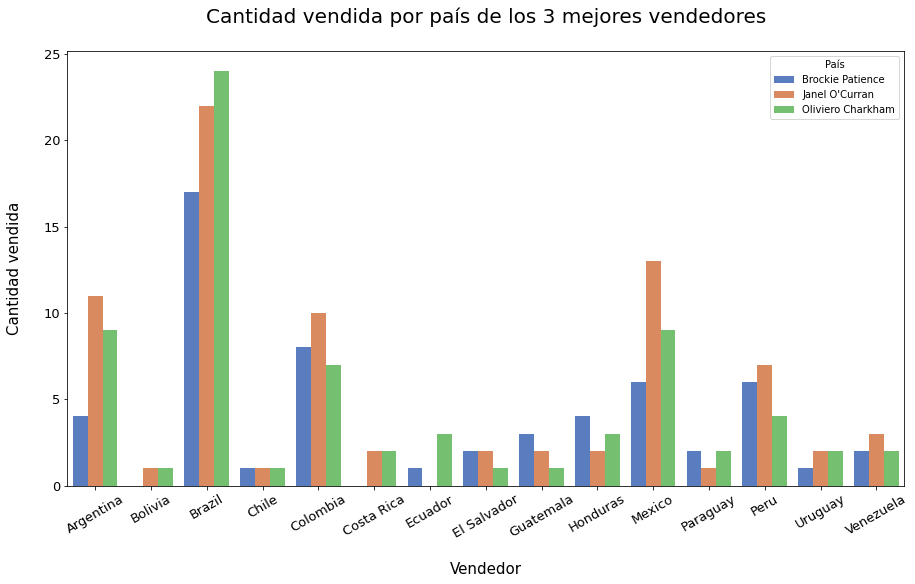

In [ ]:
rcParams['figure.figsize'] = 15,8
ax = sns.barplot(data=para_graficar, x='country_name', y='quantity', hue='seller_name', palette='muted')

ax.set_xlabel('\nVendedor', fontsize = 15)
ax.set_ylabel('Cantidad vendida\n', fontsize = 15)
ax.tick_params(axis='both' , labelsize=13)

plt.title('Cantidad vendida por país de los 3 mejores vendedores\n', fontsize=20)
plt.legend(title='País')
plt.xticks(rotation=30)
plt.show()

<h4>Respuesta</h4>
A simple vista se puede ver que los tres mejores vendedores vendieron casi la misma cantidad a cada país. Lo que se podría concluir a primera vista que los tres vendedores realizan correctamente sus tareas y la diferencia entre países no corresponde a la efectividad de cada vendedor. Es decir, la diferencia entre países se explica por otro factor y no por el trabajo de los vendedores.

<h2>Conclusiones y propuestas</h2>

<h3>Conclusiones sobre el Dataset</h3>
Consideramos tres grandes hallazgos, además de las respuestas desarrolladas anteriormente:<br><br>
<li>La posibilidad de realizar una campaña de publicidad en las semanas 3 y/o 4 para incrementar las ventas en ese período, aunque se entiende que en este tipo de rubro (venta de productos informáticos), la demanda sea mayor cuando la mayoría de la población objetivo cobra el sueldo/ingreso y decaiga para mediados y final de mes.</li>
<li>La venta de Full Pc (computadoras completas) es lo que genera mayor ingreso a la compañía, superando ampliamente al resto de los componentes.</li>
<li>Si bien la venta a Brasil es la de mayor monto, la venta a El Salvador pareciera ser al más rentable (con la salvedad explicada en la nota anteriormente).</li> 

<br>


<h3>Propuestas</h3>

Las siguientes propuestas tienen como objetivo capitalizar los hallazgos del análisis y mejorar la toma de decisiones basada en datos para aumentar la eficacia y la rentabilidad de la estrategia comercial  <br><br>
<li><b>Campañas de Marketing Estratégicas:</b> Planificar campañas publicitarias enfocadas en las semanas 3 y 4 para impulsar las ventas durante esos períodos de mayor demanda.</li>
<li><b>Enfoque en productos rentables:</b> Priorizar la promoción de Full PC, los cuales generan los mayores ingresos, mientras se busca aumentar la visibilidad de otros componentes de computadoras.</li>
<li><b>Analisis geografico detallado:</b> Investigar las diferencias de rentabilidad por país para identificar oportunidades de mercado y optimizar estrategias de expansión.</li>
<li><b>Mejora en la recopilación de datos:</b> Revisar los procesos de recopilación de datos para garantizar la fiabilidad y representatividad de la información utilizada en los análisis futuros.</li>

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=441ecb19-d114-4821-9083-6a3400a26c20' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>